In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
from scipy import stats
from datetime import datetime, date


/Users/yawamankwah/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Matplotlib is building the font cache; this may take a moment.


In [3]:
# GET ETF HISTORICAL DATA
etf = 'VOO'  #Vanguard S&P 500 ETF
period = '10y'
etf_data = yf.download(etf, period=period)['Adj Close']


[*********************100%***********************]  1 of 1 completed


In [4]:
# RETRIEVE LIST OF ASSETS FOR VOO
# https://stackoverflow.com/questions/38486477/get-html-table-into-pandas-dataframe-not-list-of-dataframe-objects

url = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies') 
web = pd.read_html(url.text)
assets = web[0]['Symbol'].tolist()
assets = sorted(assets)
# DELETE BRK.B AND BF.B BECAUSE THEY CONSTANTLY COME OUT AS DELISTED
assets.remove("BRK.B")
assets.remove("BF.B")

/var/folders/81/b_jwtb1n11j061qlxl7q9f_h0000gn/T/ipykernel_9091/3641117759.py:5: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  web = pd.read_html(url.text)


In [5]:
# RETRIEVE ASSET DATA

assets_data = yf.download(assets, period=period)
assets_price = pd.DataFrame(assets_data['Adj Close'])
assets_volume = pd.DataFrame(assets_data['Volume'])

[*********************100%***********************]  501 of 501 completed

12 Failed downloads:
['ABNB', 'CEG', 'PLTR', 'OTIS', 'CARR']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', 'ytd', 'max']")
['SW']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']")
['SOLV', 'GEV']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', 'ytd', 'max']")
['AMTM']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', 'ytd', 'max']")
['KVUE', 'VLTO', 'GEHC']: YFInvalidPeriodError("%ticker%: Period '10y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']")


In [6]:
# SLOPE 52 WEEK TREND
# https://stackoverflow.com/questions/49100471/how-to-get-slopes-of-data-in-pandas-dataframe-in-python

def polyfit(data):
    return(np.polyfit(list(range(1, 261)),data , 1)[0])

df_slope_52_week = pd.DataFrame(assets_price.rolling(window = 52*5).apply(polyfit))
df_slope_52_week = df_slope_52_week.dropna(how='all')

df_zscores_slope_52 = pd.DataFrame(stats.zscore(df_slope_52_week.transpose(), nan_policy='omit'))


In [7]:
# PERCENT ABOVE 260 DAY LOW
# https://www.investopedia.com/ask/answers/04/041604.asp#:~:text=The%20%22percentage%20off%20the%2052,or%20bottom%20of%20the%20range.

def percent_above_260_day(data):
    low = data.min()
    top = pd.Series(data).iloc[0]
    return ((top - low)/low * 100)

df_percent_above_260 = pd.DataFrame(assets_price.rolling(window=260).apply(percent_above_260_day))
df_percent_above_260 = df_percent_above_260.dropna(how='all')

df_zscores_percent_above_260 = pd.DataFrame(stats.zscore(df_percent_above_260.transpose(), nan_policy='omit'))


In [8]:
# 39 WEEK RETURN

def return_39_week(data):
    before = pd.Series(data).iloc[0]
    after = pd.Series(data).iloc[-1]
    return ((after - before)/before * 100)

df_return_39_week = pd.DataFrame(assets_price.rolling(window = 39*5).apply(return_39_week))
df_return_39_week = df_return_39_week.dropna(how='all')

df_zscores_return_39_week = pd.DataFrame(stats.zscore(df_return_39_week.transpose(), nan_policy='omit'))


In [9]:
# 51 WEEK PRICE VOLUME TREND 
# https://www.barchart.com/education/technical-indicators/price_volume_trend

rate = assets_price.pct_change(51*5)
volume_rate = assets_volume * rate
df_price_volume_trend = pd.DataFrame(assets_volume.shift(51*5) + volume_rate)
df_price_volume_trend = df_price_volume_trend.dropna(how='all')

df_zscores_pvt = pd.DataFrame(stats.zscore(df_price_volume_trend.transpose(), nan_policy='omit'))


/var/folders/81/b_jwtb1n11j061qlxl7q9f_h0000gn/T/ipykernel_9091/1438422392.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rate = assets_price.pct_change(51*5)


In [10]:
# 4/52 WEEK PRICE OSCILLATOR
# https://www.statology.org/exponential-moving-average-pandas/
# https://www.investopedia.com/articles/investing/051214/use-percentage-price-oscillator-elegant-indicator-picking-stocks.asp#:~:text=Calculating%20the%20Percentage%20Price%20Oscillator,26%2Dday%20exponential%20moving%20average.

df_price_oscillator = pd.DataFrame((assets_price.ewm(span=4*5, adjust=False).mean() - assets_price.ewm(span=26*5, adjust=False).mean())/assets_price.ewm(span=26*5, adjust=False).mean())

df_zscores_oscillator = pd.DataFrame(stats.zscore(df_price_oscillator.transpose(), nan_policy='omit'))

In [11]:
# AGGREGATE Z SCORES
aggregate_zscores = (df_zscores_slope_52 + df_zscores_return_39_week + df_zscores_oscillator + df_zscores_percent_above_260 + df_zscores_pvt)/5
aggregate_zscores = aggregate_zscores.transpose()

In [12]:
# MONTHLY Z SCORES
df_monthly_zscore = pd.DataFrame(aggregate_zscores.resample('M').mean())

/var/folders/81/b_jwtb1n11j061qlxl7q9f_h0000gn/T/ipykernel_9091/119082624.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly_zscore = pd.DataFrame(aggregate_zscores.resample('M').mean())


In [13]:
# LONG AND SHORT BUCKETS
num_stocks = 15
long_bucket = df_monthly_zscore.iloc[-1].nlargest(15)
short_bucket = df_monthly_zscore.iloc[-1].nsmallest(15)

In [14]:
# GET WEIGHTS
long_weights = long_bucket/long_bucket.sum()
short_weights = short_bucket/short_bucket.sum()
time = -5*12*4*5

In [15]:
# PORTFOLIO AND STOCK RETURNS
# https://campus.datacamp.com/courses/introduction-to-portfolio-risk-management-in-python/portfolio-investing?ex=1
stock_returns = assets_price[long_bucket.index.tolist() + short_bucket.index.tolist()][time: ].pct_change()
long_portfolio_returns = stock_returns.mul(long_weights, axis=1).sum(axis=1)
short_portfolio_returns = stock_returns.mul(short_weights, axis=1).sum(axis=1)

stock_returns['Long_Portfolio'] = long_portfolio_returns
stock_returns['Short_Portfolio'] = short_portfolio_returns
stock_returns['ETF'] = etf_data.pct_change()


In [16]:
# CUMULATIVE RETURNS
Cumulative_returns = ((1+stock_returns).cumprod()-1)
Cumulative_returns

Ticker,NVDA,NVR,VST,TSLA,FICO,BKNG,UAL,AXON,GL,TRGP,...,ALGN,ELV,SWKS,HII,LRCX,CE,MCHP,Long_Portfolio,Short_Portfolio,ETF
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-0.002739
2020-02-19,0.061132,0.001503,-0.028681,0.068756,0.002857,-0.003942,-0.010219,0.018211,0.002175,0.002442,...,0.026748,0.005323,0.020296,-0.007579,0.026157,0.004640,0.026739,0.017318,0.039938,0.002063
2020-02-20,0.040901,0.019639,-0.019264,0.047775,-0.024225,-0.002717,-0.004113,-0.009735,0.007523,0.070266,...,0.009484,-0.028137,0.006252,-0.000337,0.009682,0.010673,0.014329,0.012813,0.036320,-0.001869
2020-02-21,-0.008430,0.017965,0.002997,0.049627,-0.048937,-0.024065,-0.027792,-0.015119,-0.001722,0.061855,...,-0.035824,-0.025591,-0.018326,-0.006232,-0.026250,0.002135,-0.014282,-0.004100,0.021056,-0.012215
2020-02-24,-0.078531,0.007174,-0.016267,-0.028670,-0.064661,-0.092973,-0.059447,-0.056122,-0.033173,0.024417,...,-0.110473,-0.082493,-0.047786,-0.011200,-0.076474,-0.035267,-0.060717,-0.050095,-0.008483,-0.045249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-14,18.875930,1.318083,5.744400,4.437675,4.395819,1.533425,0.136092,5.924293,0.029786,4.729857,...,-0.178898,0.426141,-0.212089,-0.085619,2.289277,-0.237989,0.324220,5.332126,1.233163,0.894184
2024-11-15,18.228567,1.279293,5.924139,4.604380,4.251423,1.535570,0.136216,5.864620,0.031581,4.863554,...,-0.171304,0.403892,-0.214997,-0.093904,2.080811,-0.239638,0.268909,5.288720,1.197334,0.869741
2024-11-18,17.980727,1.238795,6.142361,4.919268,4.277692,1.557276,0.126371,5.872065,0.036777,4.952088,...,-0.148298,0.403927,-0.212183,-0.081078,2.103681,-0.247677,0.317155,5.312527,1.275355,0.877483


<Axes: xlabel='Date'>

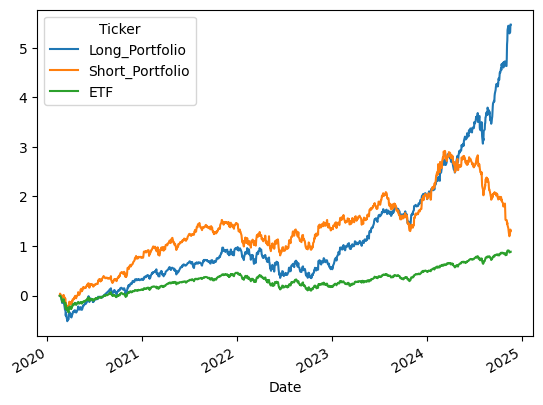

In [17]:
# CUMULATIVE PORTFOLIO RETURN VS ETF
Cumulative_returns[["Long_Portfolio", "Short_Portfolio", "ETF"]].plot()

/var/folders/81/b_jwtb1n11j061qlxl7q9f_h0000gn/T/ipykernel_9091/2530513677.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  (stock_returns.resample('M').mean())[["Long_Portfolio", "Short_Portfolio", "ETF"]].plot()


<Axes: xlabel='Date'>

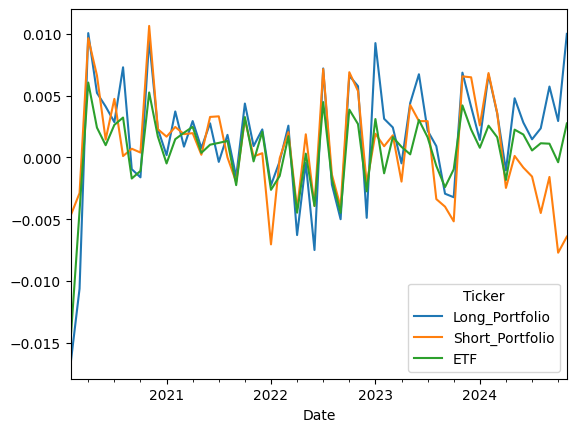

In [18]:
# MONTHLY RETURN LONG PICKS VS SHORT PICKS VS ETF
(stock_returns.resample('M').mean())[["Long_Portfolio", "Short_Portfolio", "ETF"]].plot()

In [19]:
# MONTHLY RETURNS BAR CHART
monthly_returns = stock_returns.resample('M').mean()
monthly_portfolio_returns = monthly_returns[['Long_Portfolio', 'Short_Portfolio', 'ETF']]
monthly_portfolio_returns['Long - ETF'] = monthly_portfolio_returns['Long_Portfolio'] - monthly_portfolio_returns['ETF']
monthly_portfolio_returns['Short - ETF'] = monthly_portfolio_returns['Short_Portfolio'] - monthly_portfolio_returns['ETF']
monthly_portfolio_returns


/var/folders/81/b_jwtb1n11j061qlxl7q9f_h0000gn/T/ipykernel_9091/2336701563.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = stock_returns.resample('M').mean()
/var/folders/81/b_jwtb1n11j061qlxl7q9f_h0000gn/T/ipykernel_9091/2336701563.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_portfolio_returns['Long - ETF'] = monthly_portfolio_returns['Long_Portfolio'] - monthly_portfolio_returns['ETF']
/var/folders/81/b_jwtb1n11j061qlxl7q9f_h0000gn/T/ipykernel_9091/2336701563.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

Ticker,Long_Portfolio,Short_Portfolio,ETF,Long - ETF,Short - ETF
Date,,,,,
2020-02-29,-0.016545,-0.004668,-0.014498,-0.002047,0.009829
2020-03-31,-0.010624,-0.002885,-0.004337,-0.006287,0.001452
2020-04-30,0.010059,0.009646,0.006059,0.004001,0.003588
2020-05-31,0.005221,0.006634,0.002412,0.002809,0.004222
2020-06-30,0.004119,0.001443,0.000990,0.003129,0.000453
2020-07-31,0.002857,0.004738,0.002633,0.000223,0.002105
2020-08-31,0.007293,0.000110,0.003227,0.004066,-0.003117
2020-09-30,-0.000951,0.000703,-0.001707,0.000756,0.002410
2020-10-31,-0.001611,0.000395,-0.001092,-0.000519,0.001487


In [20]:
monthly_portfolio_returns['Long_Positive'] = monthly_portfolio_returns['Long - ETF'] > 0
monthly_portfolio_returns['Short_Positive'] = monthly_portfolio_returns['Short - ETF'] > 0
monthly_portfolio_returns['ETF_Positive'] = monthly_portfolio_returns['ETF'] > 0

monthly_portfolio_returns

/var/folders/81/b_jwtb1n11j061qlxl7q9f_h0000gn/T/ipykernel_9091/402302082.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_portfolio_returns['Long_Positive'] = monthly_portfolio_returns['Long - ETF'] > 0
/var/folders/81/b_jwtb1n11j061qlxl7q9f_h0000gn/T/ipykernel_9091/402302082.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_portfolio_returns['Short_Positive'] = monthly_portfolio_returns['Short - ETF'] > 0
/var/folders/81/b_jwtb1n11j061qlxl7q9f_h0000gn/T/ipykernel_9091/402302082.py:3: 

Ticker,Long_Portfolio,Short_Portfolio,ETF,Long - ETF,Short - ETF,Long_Positive,Short_Positive,ETF_Positive
Date,,,,,,,,
2020-02-29,-0.016545,-0.004668,-0.014498,-0.002047,0.009829,False,True,False
2020-03-31,-0.010624,-0.002885,-0.004337,-0.006287,0.001452,False,True,False
2020-04-30,0.010059,0.009646,0.006059,0.004001,0.003588,True,True,True
2020-05-31,0.005221,0.006634,0.002412,0.002809,0.004222,True,True,True
2020-06-30,0.004119,0.001443,0.000990,0.003129,0.000453,True,True,True
2020-07-31,0.002857,0.004738,0.002633,0.000223,0.002105,True,True,True
2020-08-31,0.007293,0.000110,0.003227,0.004066,-0.003117,True,False,True
2020-09-30,-0.000951,0.000703,-0.001707,0.000756,0.002410,True,True,False
2020-10-31,-0.001611,0.000395,-0.001092,-0.000519,0.001487,False,True,False


In [21]:
monthly_portfolio_returns['Date'] = (pd.to_datetime(monthly_portfolio_returns.index)).date
monthly_portfolio_returns = monthly_portfolio_returns.set_index('Date')

/var/folders/81/b_jwtb1n11j061qlxl7q9f_h0000gn/T/ipykernel_9091/2499428717.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_portfolio_returns['Date'] = (pd.to_datetime(monthly_portfolio_returns.index)).date


<Axes: ylabel='Date'>

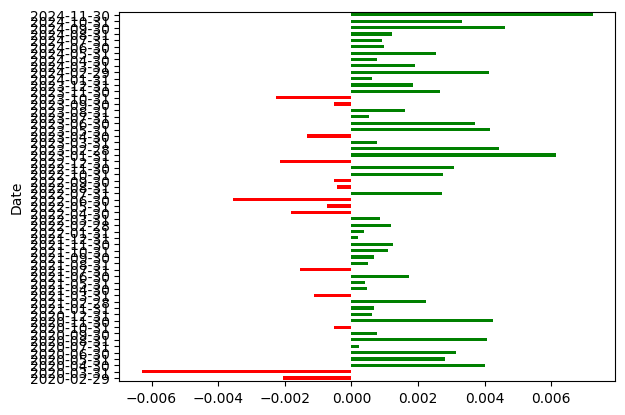

In [22]:
monthly_portfolio_returns['Long - ETF'].plot(
    kind='barh', color = monthly_portfolio_returns.Long_Positive.map({
        True: 'g', False: 'r'
    })
)

<Axes: title={'center': 'Long Portfolio vs ETF'}, ylabel='Date'>

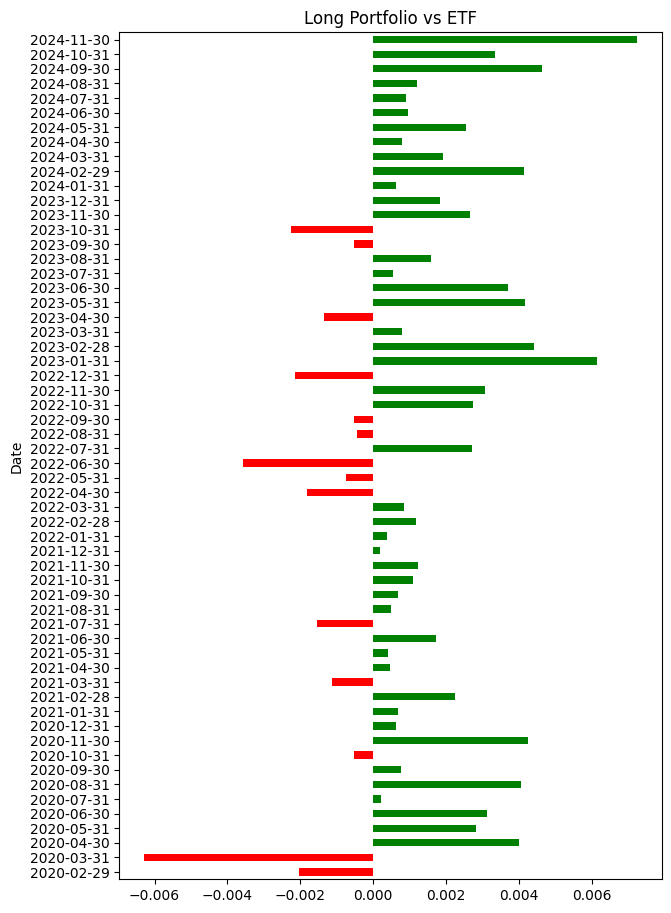

In [23]:
# LONG PORTFOLIO VS ETF
# POSITIVE (GREEN) = LONG RETURN BETTER THAN ETF RETURN
monthly_portfolio_returns['Long - ETF'].plot(kind='barh', 
                                             color = monthly_portfolio_returns.Long_Positive.map({True: 'g', False: 'r'}),
                                             title='Long Portfolio vs ETF', figsize=[7,11]
)

<Axes: title={'center': 'Short Portfolio vs ETF'}, ylabel='Date'>

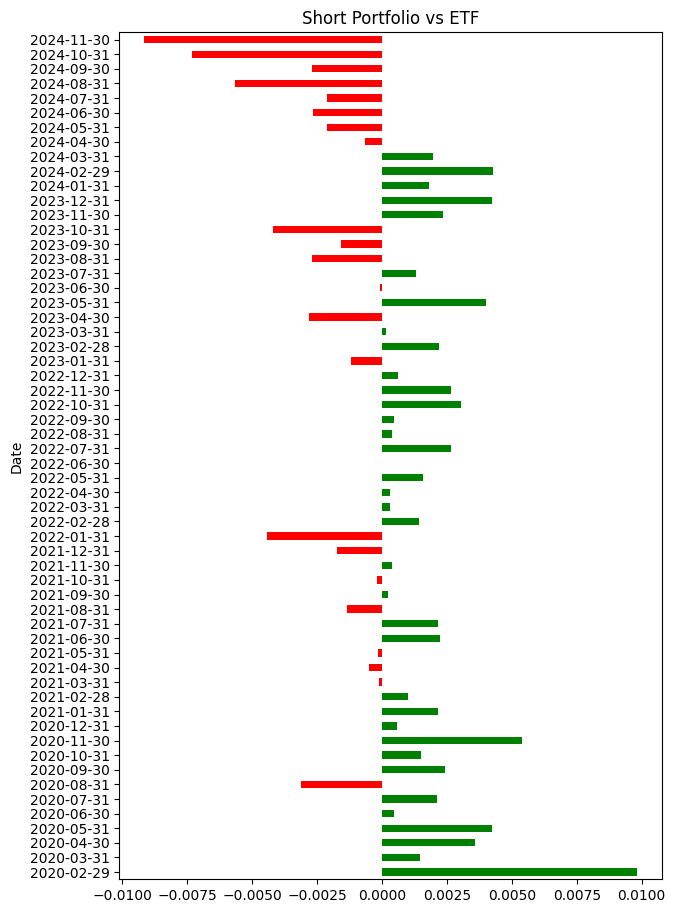

In [24]:
# SHORT PORTFOLIO VS ETF
# POSITIVE (GREEN) = SHORT RETURN BETTER THAN ETF RETURN
monthly_portfolio_returns['Short - ETF'].plot(kind='barh', 
                                             color = monthly_portfolio_returns.Short_Positive.map({True: 'g', False: 'r'}),
                                             title='Short Portfolio vs ETF', figsize=[7,11]
)

<Axes: title={'center': 'ETF Perfomance'}, ylabel='Date'>

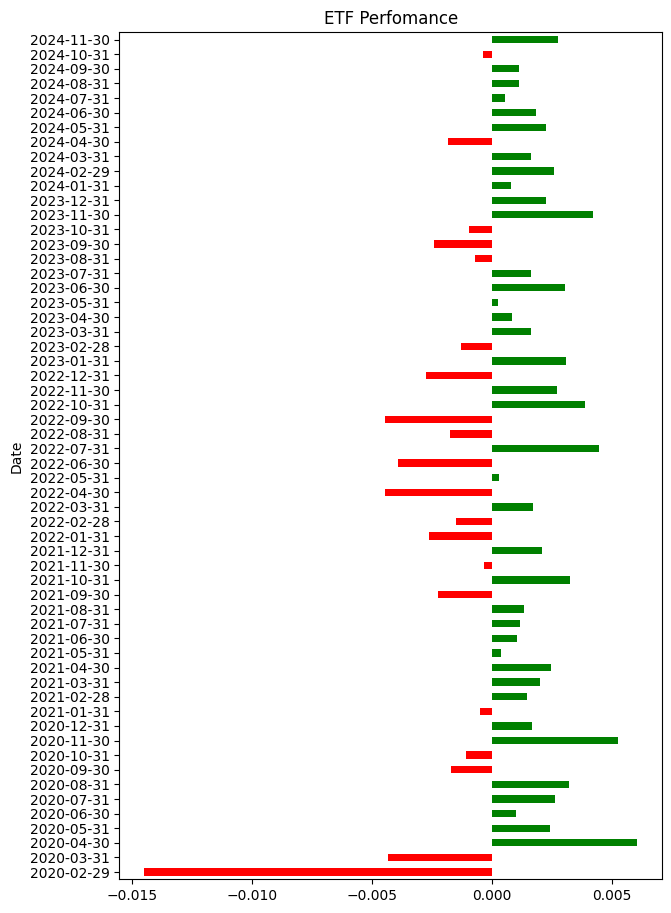

In [25]:
# ETF
monthly_portfolio_returns['ETF'].plot(kind='barh', 
                                             color = monthly_portfolio_returns.ETF_Positive.map({True: 'g', False: 'r'}),
                                             title='ETF Perfomance', figsize=[7,11]
)

